In [10]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel
from src import config
from src.plots import PlotGenerator

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [12]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [13]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the dataset: (110527, 21)
Final columns in the dataset: Index(['Gender

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Clustering Analysis
This section covers unsupervised clustering using PCA, KMeans, and Gaussian Mixture Models (GMM). We will visualize clusters, tune hyperparameters, and evaluate using Silhouette and Davies-Bouldin scores.

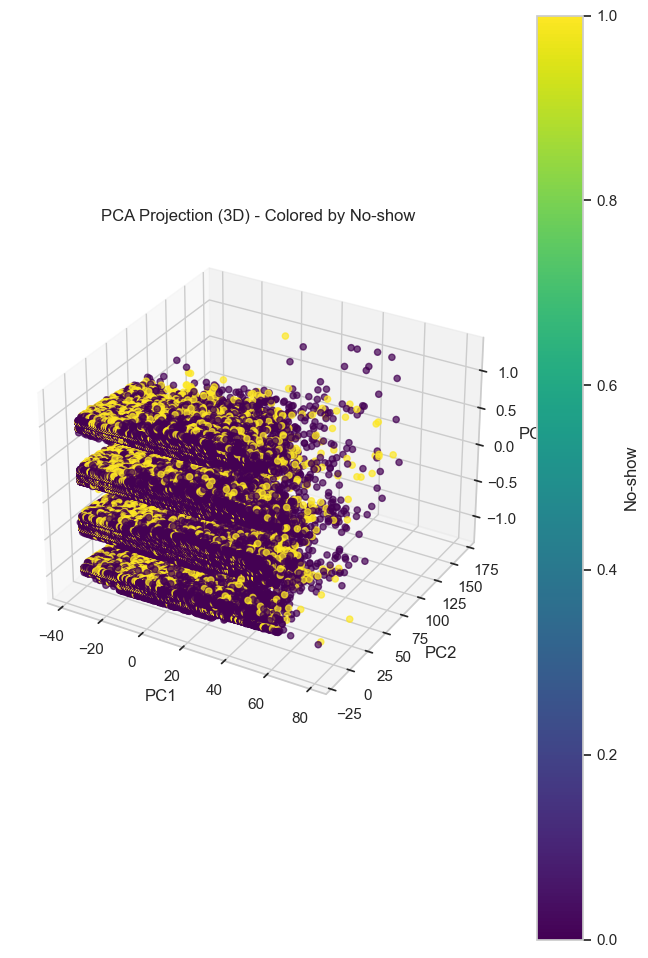

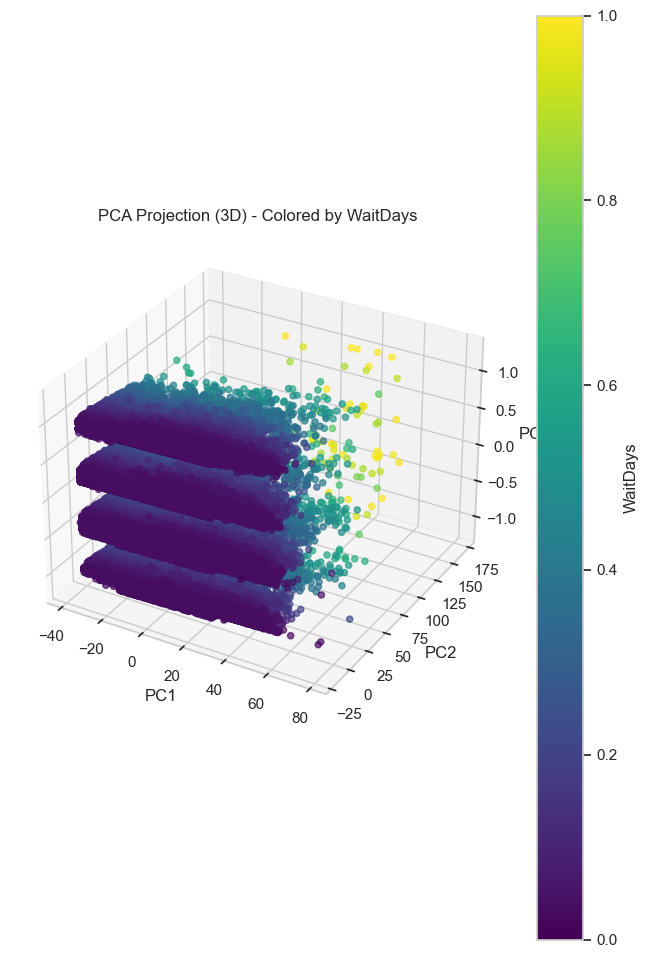

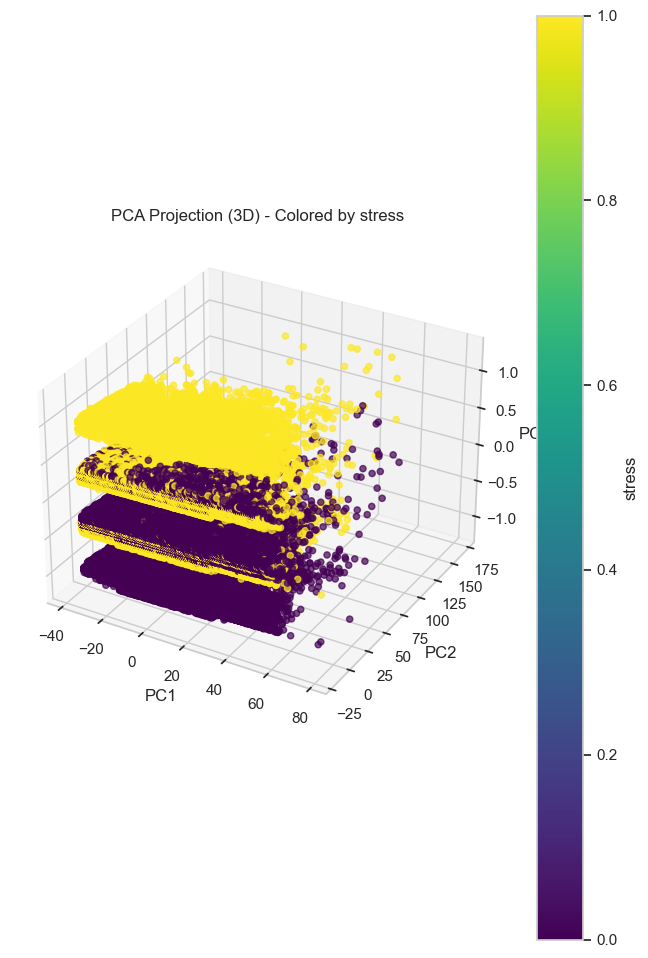

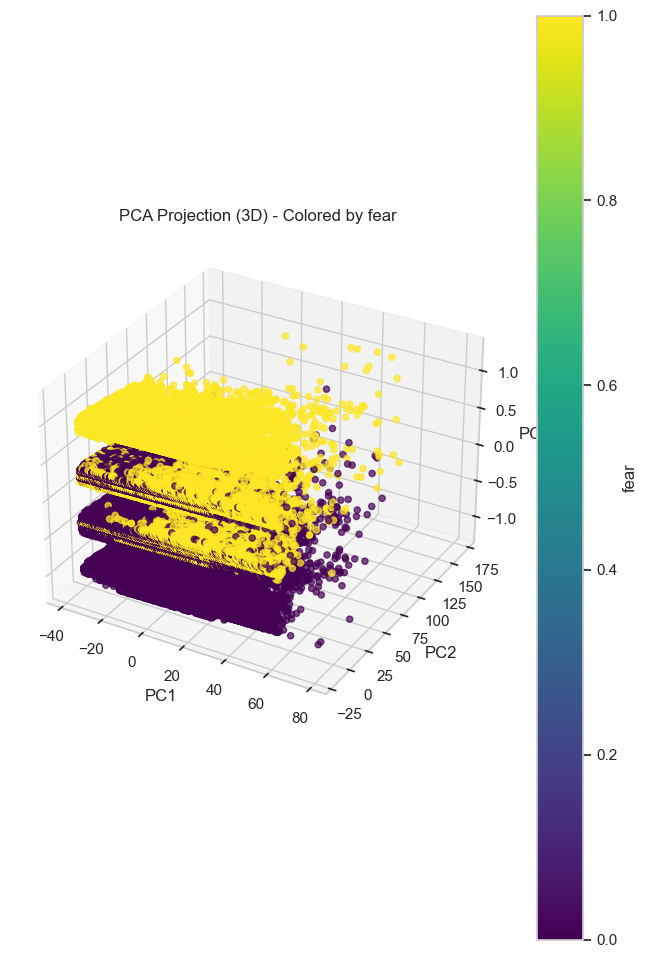

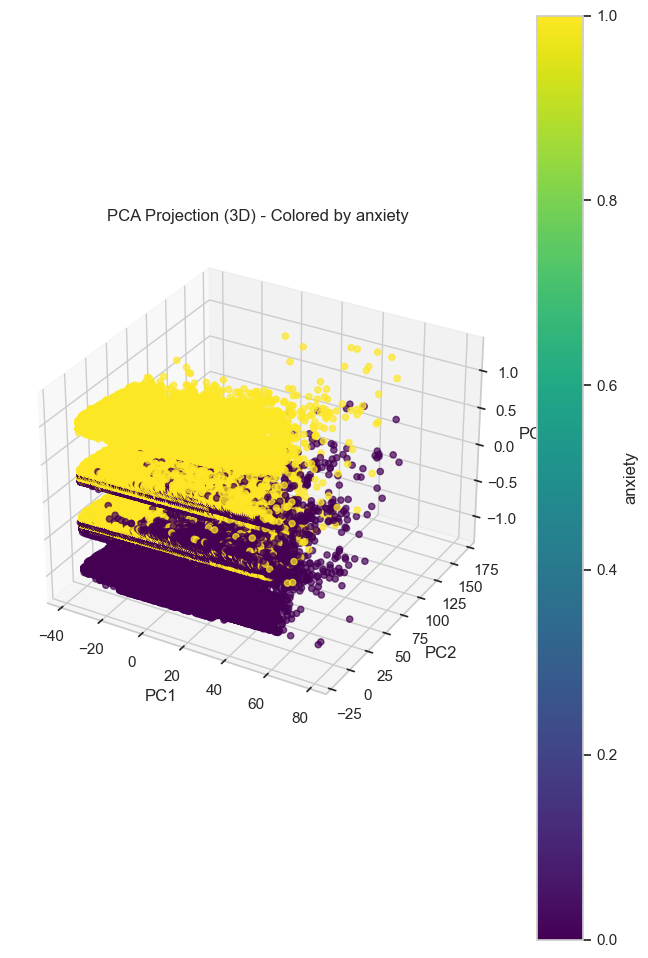

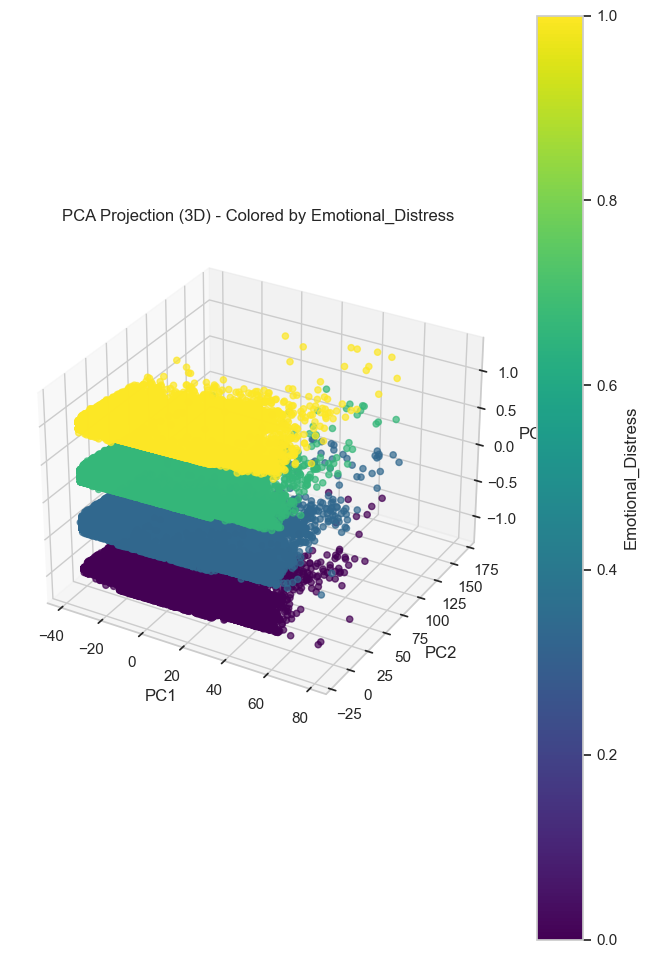

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA transformation
pca = PCA(n_components=3, random_state=RANDOM_STATE)
clustering_df = df.select_dtypes(include=[np.number])
clustering_df['Emotional_Distress'] = clustering_df[['stress', 'fear', 'anxiety']].mean(axis=1)
pca_result = pca.fit_transform(clustering_df)

def plot_pca_colored_by_feature(df, feature_name, pca_result=None, random_state=42):
    
    # Normalize the feature for color mapping
    color_vals = df[feature_name]
    norm_colors = (color_vals.to_numpy() - color_vals.min()) / (color_vals.max() - color_vals.min())
    colors = plt.cm.viridis(norm_colors)

    # Plot
    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                         c=colors, alpha=0.7)

    ax.set_title(f'PCA Projection (3D) - Colored by {feature_name}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Add color bar
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    cbar.set_label(feature_name)

    plt.show()

# Run PCA and plot
plot_pca_colored_by_feature(clustering_df, 'No-show', pca_result)
plot_pca_colored_by_feature(clustering_df, 'WaitDays', pca_result)
plot_pca_colored_by_feature(clustering_df, 'stress', pca_result)
plot_pca_colored_by_feature(clustering_df, 'fear', pca_result)
plot_pca_colored_by_feature(clustering_df, 'anxiety', pca_result)
plot_pca_colored_by_feature(clustering_df, 'Emotional_Distress', pca_result)

   Principal Component  Explained Variance Ratio  Cumulative Variance
0               Gender                  0.158061             0.158061
1                  Age                  0.147942             0.306003
2          Scholarship                  0.108426             0.414429
3         Hypertension                  0.075337             0.489766
4             Diabetes                  0.067527             0.557292
5           Alcoholism                  0.062296             0.619588
6              Handcap                  0.059952             0.679541
7         SMS_received                  0.056173             0.735714
8              No-show                  0.049207             0.784921
9             WaitDays                  0.045115             0.830037
10             anxiety                  0.043134             0.873171
11              stress                  0.039367             0.912538
12           confusion                  0.034868             0.947406
13             hopef

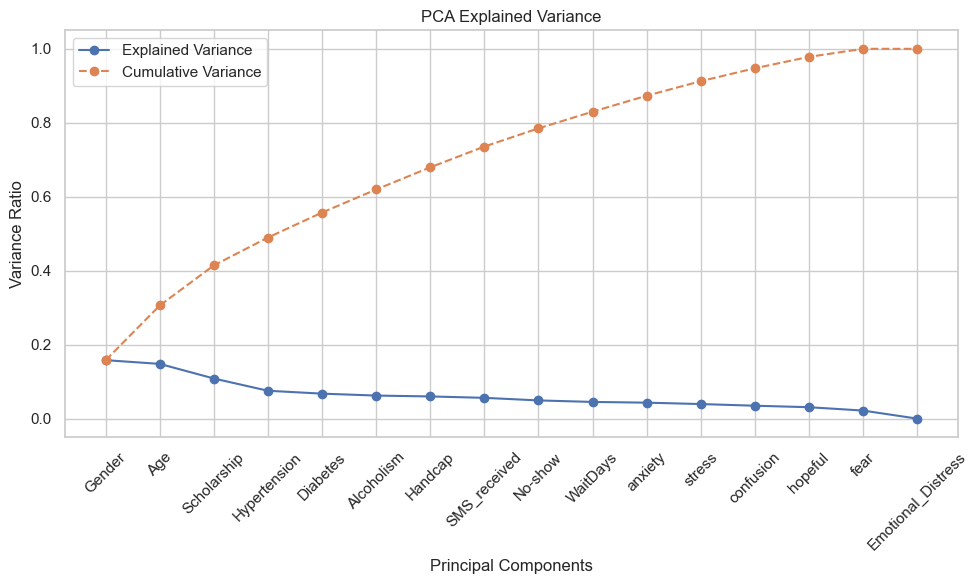

In [15]:
from sklearn.preprocessing import StandardScaler


# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df)

# Step 3: Apply PCA
pca = PCA(n_components=None, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Create a DataFrame with PCA results
pca_columns = clustering_df.columns.tolist()  
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Step 5: Explained variance summary
explained_variance = pca.explained_variance_ratio_
explained_df = pd.DataFrame({
    'Principal Component': pca_columns,
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': np.cumsum(explained_variance)
})

# Display the explained variance
print(explained_df)

# Optional: Preview the transformed data
print(pca_df.head())

# Plot explained variance and cumulative variance
plt.figure(figsize=(10, 6))

# Explained variance
plt.plot(explained_df['Principal Component'], 
         explained_df['Explained Variance Ratio'], 
         marker='o', label='Explained Variance')

# Cumulative variance
plt.plot(explained_df['Principal Component'], 
         explained_df['Cumulative Variance'], 
         marker='o', linestyle='--', label='Cumulative Variance')

plt.title('PCA Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Number of components to retain ≥ 90% variance: 12


Emotional_Distress    0.575977
fear                  0.471776
anxiety               0.357575
stress                0.356088
Hypertension          0.281256
Name: PC1, dtype: float64

Age             0.425115
Hypertension    0.424084
confusion       0.391338
anxiety         0.346938
Diabetes        0.316927
Name: PC2, dtype: float64

SMS_received    0.542773
WaitDays        0.445763
hopeful         0.369628
Age             0.251454
Hypertension    0.240810
Name: PC3, dtype: float64

Feature Contributions to PCA Components:
            Gender           Age   Scholarship  Hypertension      Diabetes  \
PC1  -5.837364e-03  1.196770e-01 -2.650962e-03  2.812564e-01  2.134812e-01   
PC2  -2.922519e-02  4.251152e-01 -1.368067e-01  4.240844e-01  3.169267e-01   
PC3  -1.874359e-01  2.514545e-01  1.135061e-01  2.408097e-01  2.024550e-01   
PC4  -4.289357e-01 -1.430078e-02  6.128584e-01  4.848147e-02  7.266704e-02   
PC5   4.684101e-01  2.633773e-02  2.858862e-01  5.194370e-02 -5.432969e-03   
PC6  -1.679672e-01 -5.768804e-02  2.836091e-01 -2.583521e-02 -2.129636e-02   
PC7  -2.703040e-01 -1.160922e-02  2.147822e-01  1.677240e-02 -3.281956e-02   
PC8   5.402639e-01 -2.459760e-01  9.289261e-02  6.026642e-02  3.229407e-01   
PC9   2.195234e-01 -9.583449e-03  1.535400e-01  5.151367e-02  1.192008e-01   
PC10  2.360314e-01 -4.218770e-02  5.409839e-01  5.497996e-02  2.508276e-02   
PC11 -1.762699e-01 -2.666693e-01 -9.259017e-02 -1.622846e-01  7.856117e-01   
PC12  4.919207e-02  2.4

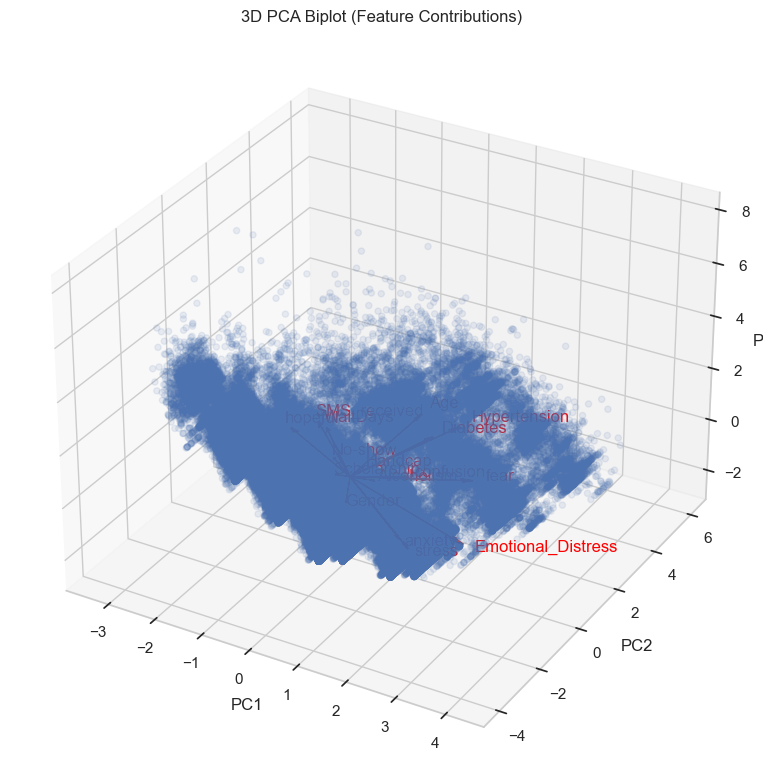

In [16]:
# Step 3: Determine top_n for 90% variance
target_variance = 0.90
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
top_n = np.argmax(cumulative_variance >= target_variance) + 1

print(f"Number of components to retain ≥ {target_variance*100:.0f}% variance: {top_n}")

# Step 4: Reduce PCA data
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_reduced = pca_df.iloc[:, :top_n]


loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(len(pca_columns))], 
                        index=pca_columns)
display(loadings['PC1'].abs().sort_values(ascending=False).head(5))
display(loadings['PC2'].abs().sort_values(ascending=False).head(5))
display(loadings['PC3'].abs().sort_values(ascending=False).head(5))

# Feature contributions to PCA components
feature_contribution = pd.DataFrame(
    pca.components_,
    columns=pca_columns,
    index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
)

print("Feature Contributions to PCA Components:")
print(feature_contribution)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of samples in PC space (optional)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.1)

# Add feature vectors
for i, feature in enumerate(loadings.index):
    ax.quiver(0, 0, 0,
              loadings.iloc[i, 0]*5,
              loadings.iloc[i, 1]*5,
              loadings.iloc[i, 2]*5,
              color='r', arrow_length_ratio=0.1)
    ax.text(loadings.iloc[i, 0]*5.5,
            loadings.iloc[i, 1]*5.5,
            loadings.iloc[i, 2]*5.5,
            feature, color='red')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Biplot (Feature Contributions)')
plt.tight_layout()
plt.show()

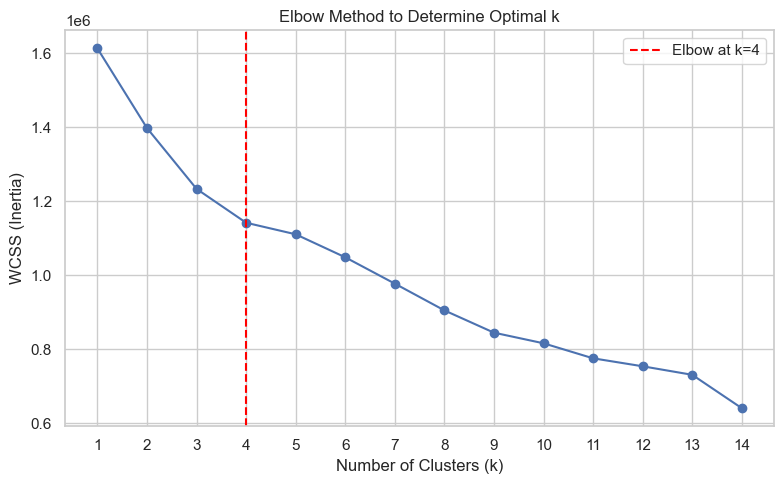

In [17]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

# Step 5: Elbow Method - compute WCSS for different k
wcss = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)

# Find the elbow point using KneeLocator
knee_locator = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Step 6: Plot Elbow Curve with elbow point
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
if optimal_k is not None:
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_values)
plt.grid(True)
if optimal_k is not None:
    plt.legend()
plt.tight_layout()
plt.show()

Evaluating k=2...


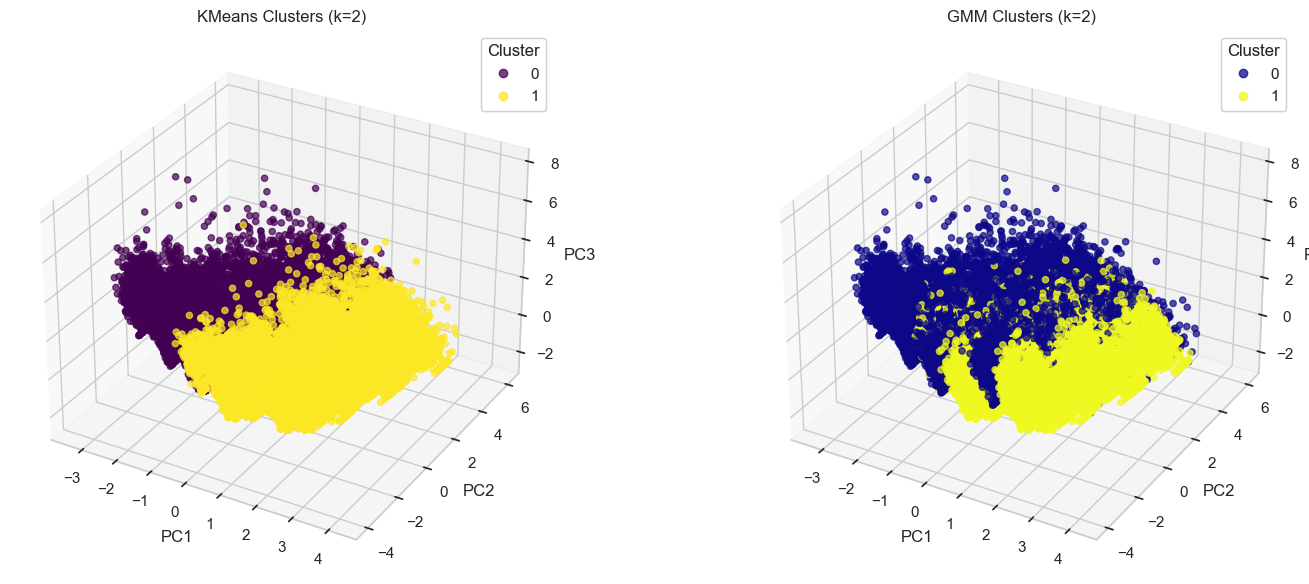

Evaluating k=3...


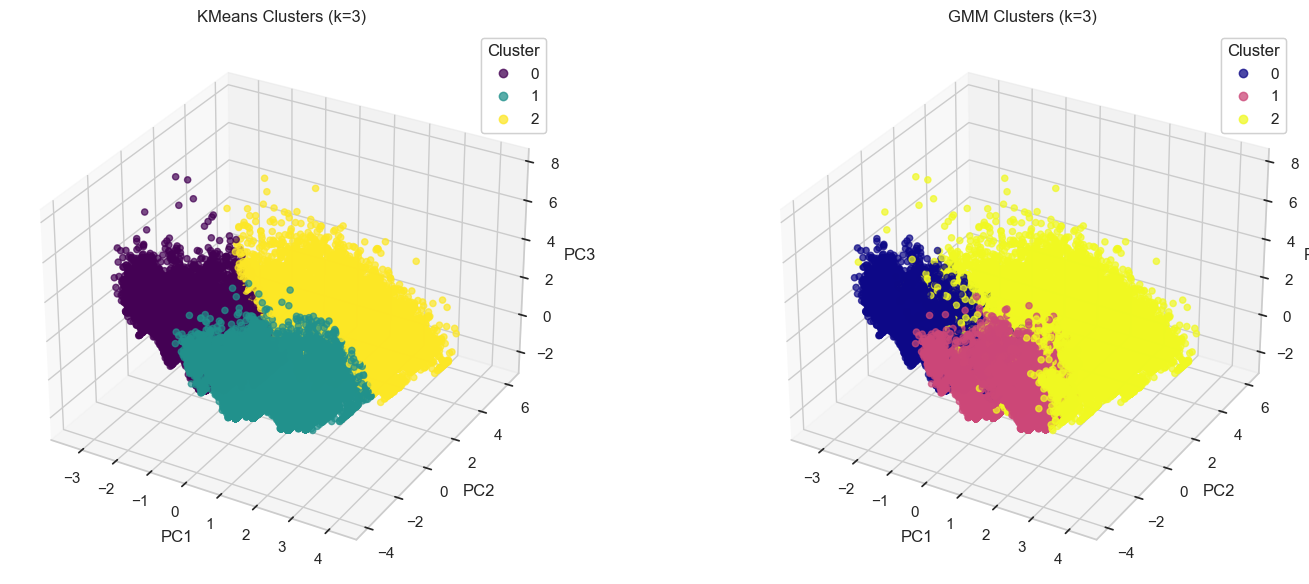

Evaluating k=4...


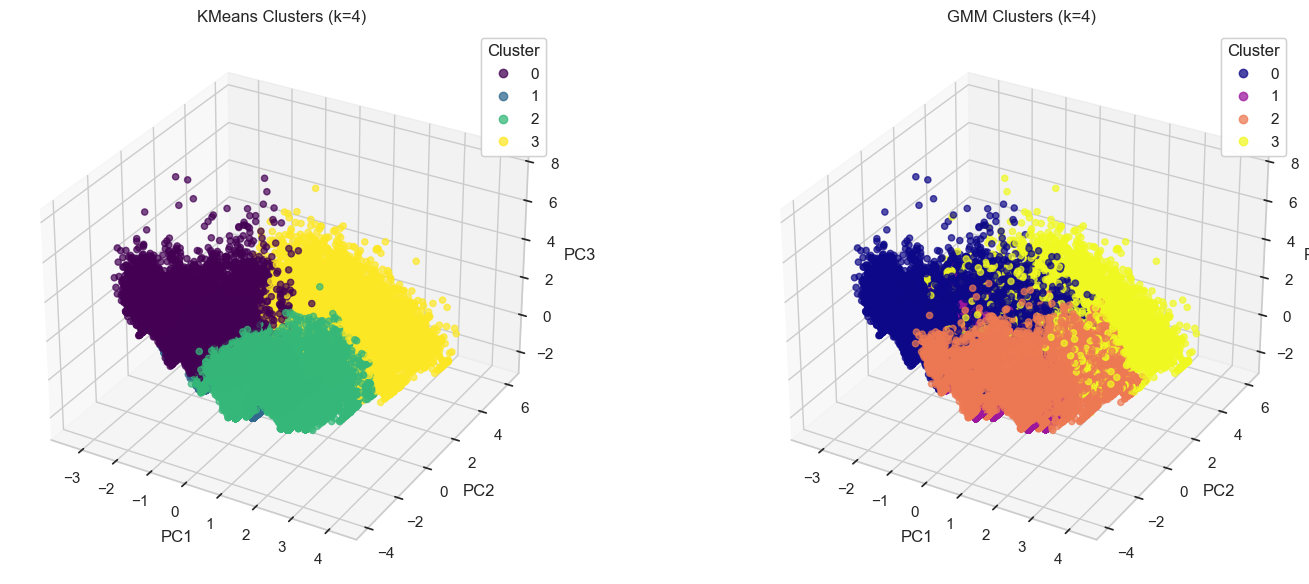

Evaluating k=5...


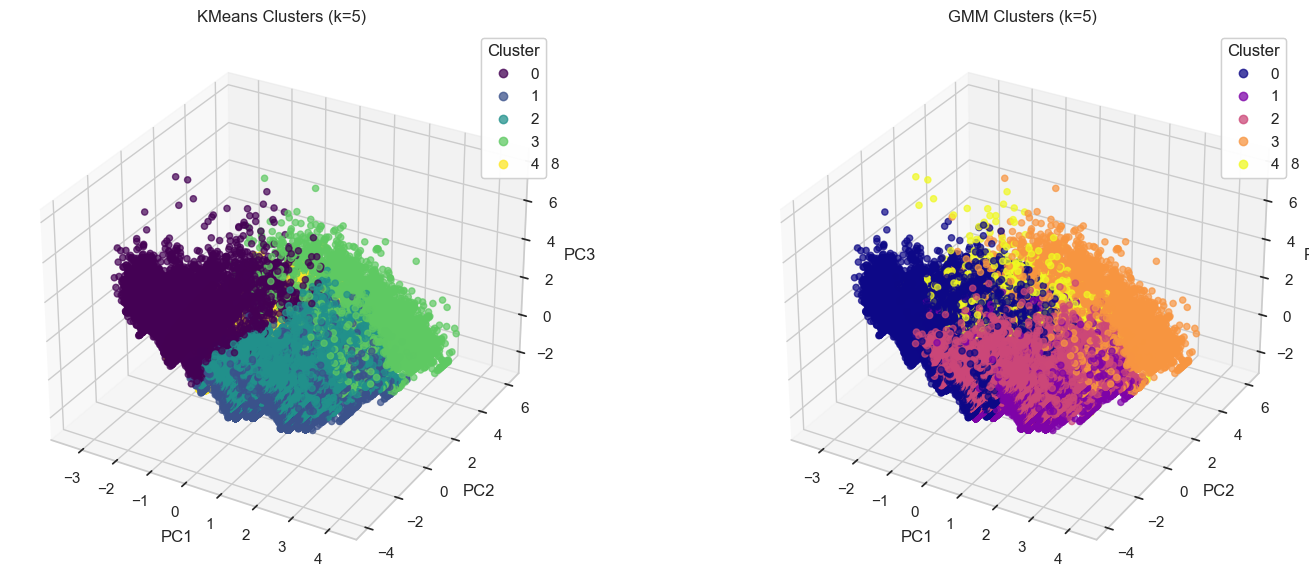

Evaluating k=6...


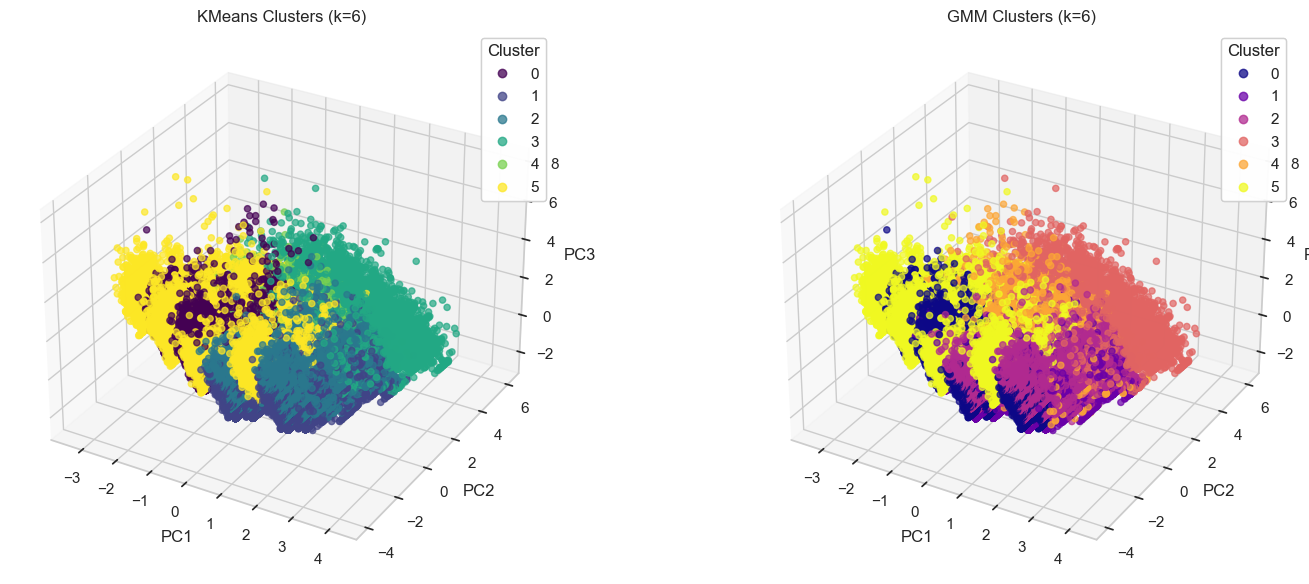

Evaluating k=7...


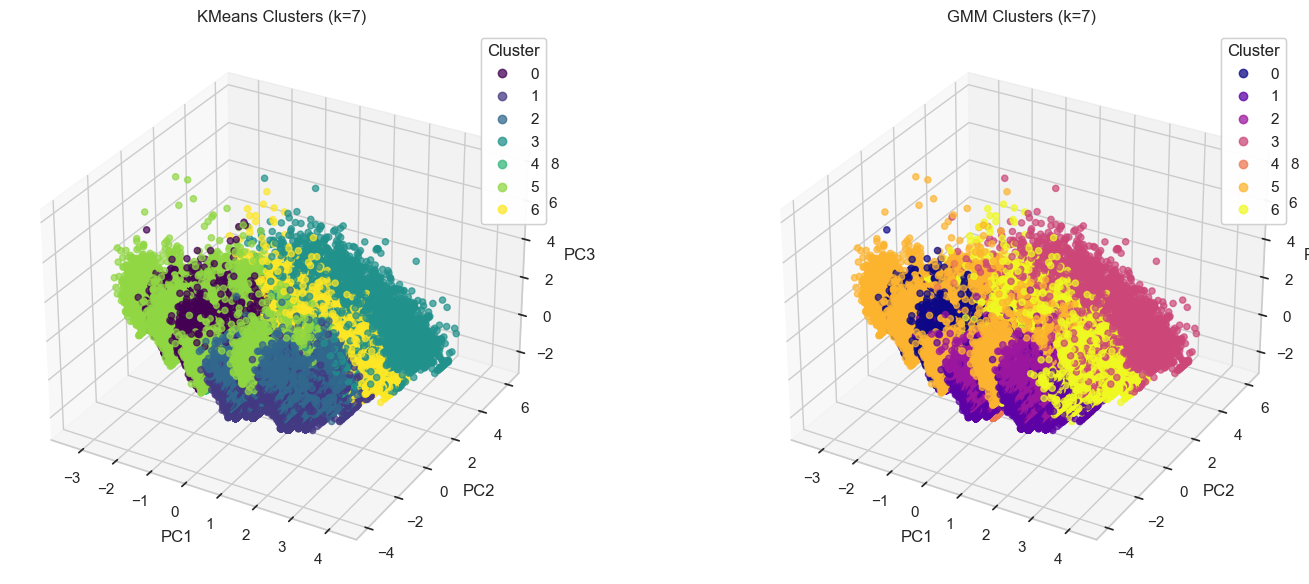

KMeans Scores:


,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.149469,2.362974,17040.899952
1,3,0.159410,1.979499,17031.376850
2,4,0.156826,1.926499,15220.880310
3,5,0.148039,2.144949,12514.400976
4,6,0.143271,2.133656,11918.071831
5,7,0.151726,2.053563,12000.062477


GMM Scores:


,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.123373,2.854363,11978.691579
1,3,0.136138,2.081933,15652.595005
2,4,0.108175,2.442408,10218.271841
3,5,0.131484,2.291960,10885.989708
4,6,0.146783,2.028767,11463.835968
5,7,0.129871,2.090990,11068.460509


In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_reduced is already defined and contains the PCA-reduced data

# Define k range
k_values = range(2, 8)

# Initialize score lists for KMeans
kmeans_silhouette_scores = []
kmeans_davies_bouldin_scores = []
kmeans_calinski_harabasz_scores = []

# Initialize score lists for GMM
gmm_silhouette_scores = []
gmm_davies_bouldin_scores = []
gmm_calinski_harabasz_scores = []

for k in k_values:
    print(f"Evaluating k={k}...")
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(X_reduced)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_reduced)

    # Compute metrics for KMeans
    kmeans_silhouette = silhouette_score(X_reduced, kmeans_labels)
    kmeans_davies = davies_bouldin_score(X_reduced, kmeans_labels)
    kmeans_calinski = calinski_harabasz_score(X_reduced, kmeans_labels)

    kmeans_silhouette_scores.append(kmeans_silhouette)
    kmeans_davies_bouldin_scores.append(kmeans_davies)
    kmeans_calinski_harabasz_scores.append(kmeans_calinski)

    # Compute metrics for GMM
    gmm_silhouette = silhouette_score(X_reduced, gmm_labels)
    gmm_davies = davies_bouldin_score(X_reduced, gmm_labels)
    gmm_calinski = calinski_harabasz_score(X_reduced, gmm_labels)

    gmm_silhouette_scores.append(gmm_silhouette)
    gmm_davies_bouldin_scores.append(gmm_davies)
    gmm_calinski_harabasz_scores.append(gmm_calinski)

    # 3D plot for each k, side by side
    fig = plt.figure(figsize=(16, 6))
    # KMeans plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    scatter1 = ax1.scatter(
        X_reduced.iloc[:, 0],
        X_reduced.iloc[:, 1],
        X_reduced.iloc[:, 2],
        c=kmeans_labels,
        cmap='viridis',
        alpha=0.7
    )
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_title(f'KMeans Clusters (k={k})')
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Cluster")
    ax1.add_artist(legend1)
    # GMM plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    scatter2 = ax2.scatter(
        X_reduced.iloc[:, 0],
        X_reduced.iloc[:, 1],
        X_reduced.iloc[:, 2],
        c=gmm_labels,
        cmap='plasma',
        alpha=0.7
    )
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    ax2.set_title(f'GMM Clusters (k={k})')
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Cluster")
    ax2.add_artist(legend2)
    plt.tight_layout()
    plt.show()

# Create DataFrames of scores
kmeans_score_df = pd.DataFrame({
    'k': k_values,
    'Silhouette Score': kmeans_silhouette_scores,
    'Davies-Bouldin Score': kmeans_davies_bouldin_scores,
    'Calinski-Harabasz Score': kmeans_calinski_harabasz_scores
})
gmm_score_df = pd.DataFrame({
    'k': k_values,
    'Silhouette Score': gmm_silhouette_scores,
    'Davies-Bouldin Score': gmm_davies_bouldin_scores,
    'Calinski-Harabasz Score': gmm_calinski_harabasz_scores
})

# Display scores tables
print('KMeans Scores:')
display(kmeans_score_df)
print('GMM Scores:')
display(gmm_score_df)

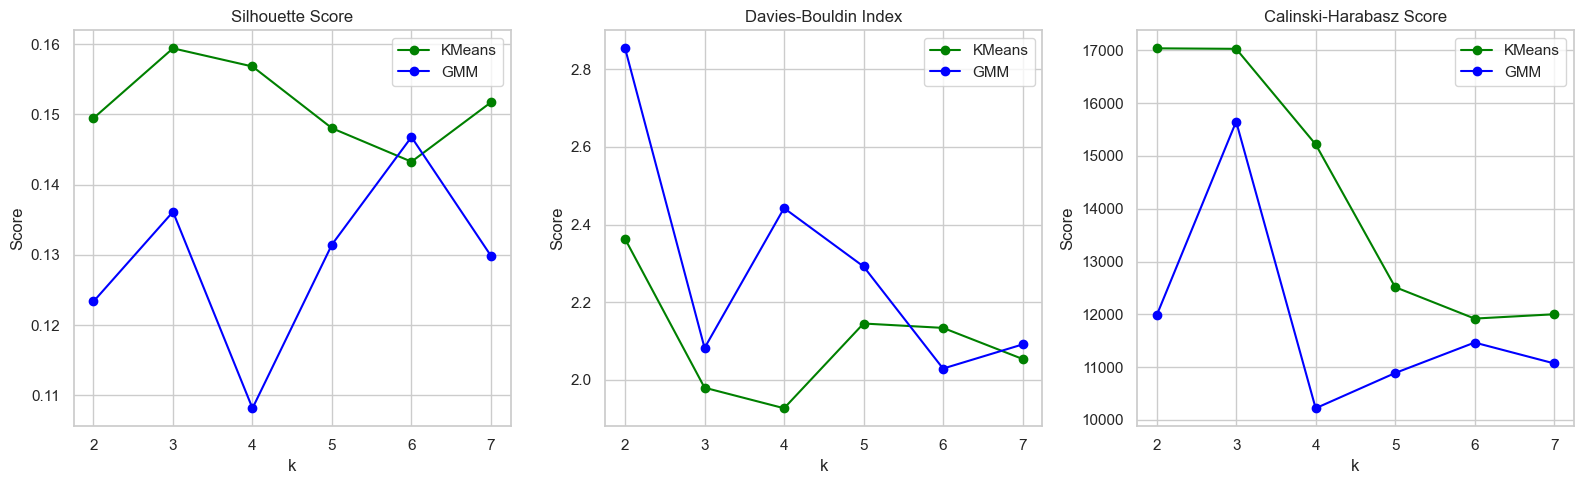

In [21]:
plt.figure(figsize=(16, 5))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(kmeans_score_df['k'], kmeans_score_df['Silhouette Score'], marker='o', color='green', label='KMeans')
plt.plot(gmm_score_df['k'], gmm_score_df['Silhouette Score'], marker='o', color='blue', label='GMM')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Davies–Bouldin Score
plt.subplot(1, 3, 2)
plt.plot(kmeans_score_df['k'], kmeans_score_df['Davies-Bouldin Score'], marker='o', color='green', label='KMeans')
plt.plot(gmm_score_df['k'], gmm_score_df['Davies-Bouldin Score'], marker='o', color='blue', label='GMM')
plt.title('Davies-Bouldin Index')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Calinski–Harabasz Score
plt.subplot(1, 3, 3)
plt.plot(kmeans_score_df['k'], kmeans_score_df['Calinski-Harabasz Score'], marker='o', color='green', label='KMeans')
plt.plot(gmm_score_df['k'], gmm_score_df['Calinski-Harabasz Score'], marker='o', color='blue', label='GMM')
plt.title('Calinski-Harabasz Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()